In [50]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)
import config


In [139]:
path = config.scope
# filename = config.scope+"coincidece_preamp_v5/1_scintillator_light_output_test.joblib"
# filename = config.scope+"coincidece_preamp_v5/2_short_long_bar.joblib"
# filename = config.scope+"coincidence_preamp_v5/3_scintillator_light_output_test_newSiPM.joblib"
# filename = config.scope+"coincidence_preamp_v5/5_scintillator_41V_2.joblib"
filename = config.scope+"coincidence_preamp_v5/11_scintillator_41.7V_LED_calibration_test_0_2.joblib"


data_save=joblib.load(filename)
time_series = data_save["metadata"]["time_series"]*1e9

Text(0.5, 0, 'Time [ns]')

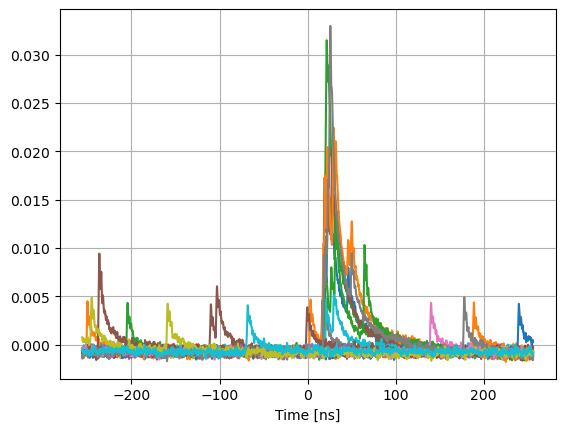

In [140]:
# Have a look at one pulse
for i in range(20):
    plot(time_series, data_save[1][i])
grid()
xlabel("Time [ns]")

In [141]:
traces = data_save[2]
traces_coinc = data_save[1]
trace_length = len(traces[0])
pre_trig = trace_length//2-100

pulse_info = hp.get_pulses_info(traces, pre_trig=pre_trig, threshold_in_sigma=7, gaussian_filter_sigma=2, gaussian_filter_order=0)
pulse_info_coinc = hp.get_pulses_info(traces_coinc, pre_trig=pre_trig, threshold_in_sigma=7, gaussian_filter_sigma=2, gaussian_filter_order=0)
# [trace_means,trace_max,trace_std,trace_slope,trace_skew, trace_pileups, trace_trigger_point, trace_amp]

Trigger threshold 0.0032398261537309736
Trigger threshold 0.0015015792741905898


Text(0.5, 0, 'dt [samples]')

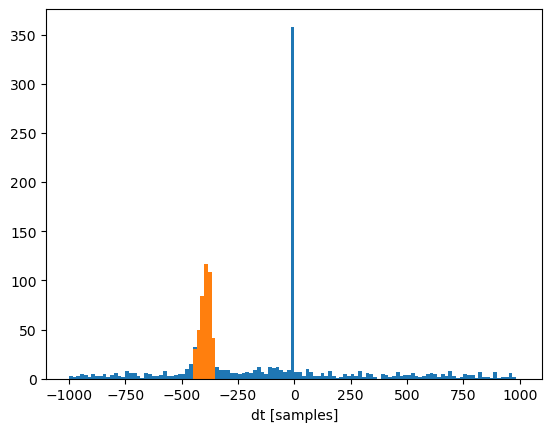

In [142]:
# Cut on dt
dt  = pulse_info[:, 6] - pulse_info_coinc[:, 6]
mask_dt = abs(dt+400)<50 # 50 samples is 50/16 = 4 ns

hist(dt, bins=120, range=(-1000,1000));
hist(dt[mask_dt], bins=120, range=(-1000,1000));
xlabel("dt [samples]")

Text(0.5, 0, 'Trigger point [samples]')

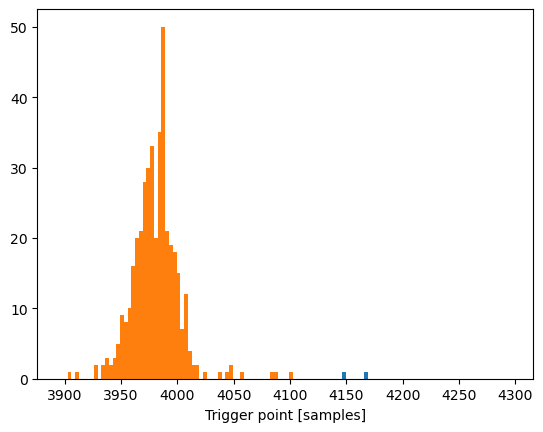

In [143]:
# Cut on trigger point
trace_trigger_point  = pulse_info[:, 6]
mask_trigger = (trace_trigger_point>pre_trig-100) & (trace_trigger_point<pre_trig+150)

hist(trace_trigger_point[mask_dt], bins=120, range=(pre_trig-100,pre_trig+300));
hist(trace_trigger_point[mask_dt&mask_trigger], bins=120, range=(pre_trig-100,pre_trig+300));
xlabel("Trigger point [samples]")

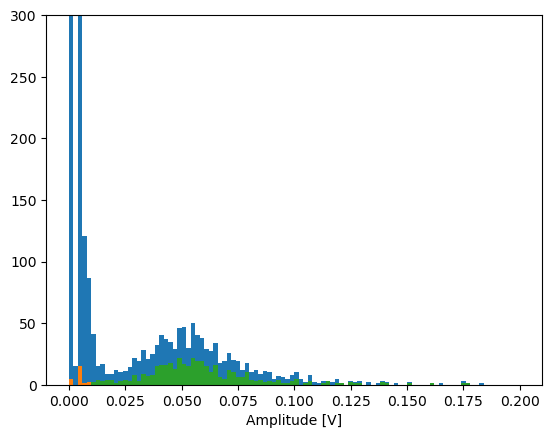

Text(0, 0.5, 'Baseline [mV]')

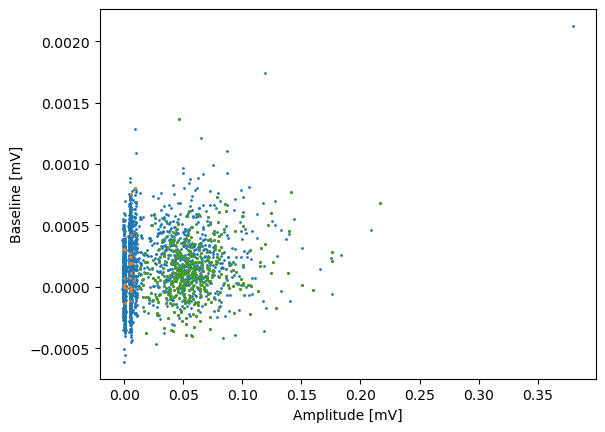

In [144]:
# Cut on amplitude and baseline
trace_amp = pulse_info[:,-1]
trace_baseline = pulse_info[:,0]
mask_baseline = (trace_amp>0.01)&(trace_baseline>-0.003)&(trace_baseline<0.02)

hist(trace_amp, range=(0,0.2), bins=100);
hist(trace_amp[mask_dt], range=(0,0.2), bins=100);
hist(trace_amp[mask_dt&mask_baseline], range=(0,0.2), bins=100);
ylim(0,300)
xlabel("Amplitude [V]")
show()

scatter(trace_amp, trace_baseline, s=1)
scatter(trace_amp[mask_dt], trace_baseline[mask_dt], s=1)
scatter(trace_amp[mask_dt&mask_baseline], trace_baseline[mask_dt&mask_baseline], s=1)
# hist(pulse_info[:,ind_amp], bins=100, range=(0,0.02));
xlabel("Amplitude [mV]")
ylabel("Baseline [mV]")

Text(0.5, 0, 'time [ns]')

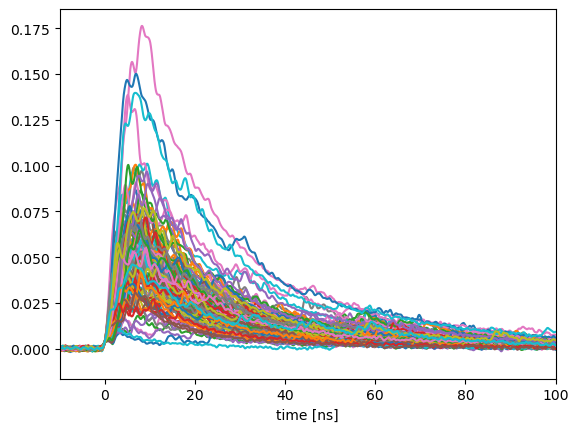

In [145]:
mask = mask_dt & mask_baseline & mask_trigger

traces_processed = []
for i in np.flatnonzero(mask):
    trigger_delay = int(trace_trigger_point[i])
    trace = np.roll(traces[i], -(trigger_delay+int(trace_length//2)))
    traces_processed.append(trace)

for i in traces_processed[:100]:
    plot(time_series, i)

xlim(-10,100)
xlabel("time [ns]")

In [128]:
# traces = data_save[1]
# pre_trig = 1000
# amplitude_cut=0.006*9

# inds_keep, passage  = hp.cut_pulses(traces, cut_amp = None, cut_baseline="auto", cut_triggerpoint = False, cut_pileups= False, cut_iterations = 2, 
#                                     pre_trig=pre_trig, threshold_in_sigma=6, gaussian_filter_sigma=2)

# traces_processed = []
# for i in inds_keep:
#     trace = traces[i]
#     trace -= np.mean(trace[:pre_trig])
#     trigger_point = np.argmax(trace>trigger_threshold_edge)
#     trace = np.roll(trace, -(trigger_point-1000))
#     if max(trace)<amplitude_cut:
#         continue
#     traces_processed.append(trace)
    

5.889715598673079,5.93195134905752,45.70163540463976,163325.47700306264,317.8162058158536,0.26444293225607657,0.05012024725855883


/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:62: RuntimeWarning: divide by zero encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:62: RuntimeWarning: invalid value encountered in true_divide
  pulse/=max(pulse)


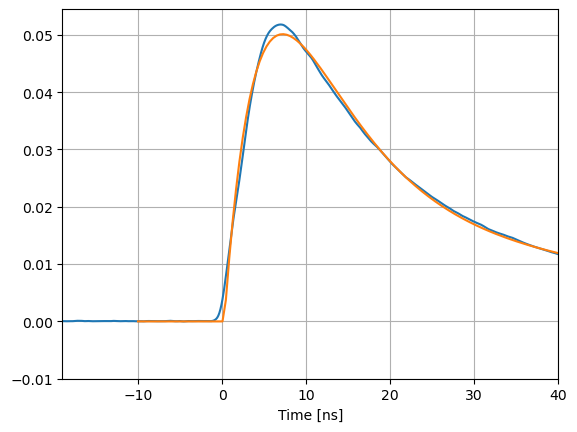

In [129]:
trace_original = traces_processed
trace_original_avg = np.mean(trace_original, axis=0)#*np.mean(trace_amps)
trace_original_avg-=np.mean(trace_original_avg[:pre_trig])
# trace_original_avg/=max(trace_original_avg)



plot(time_series, trace_original_avg)

x=time_series
y=trace_original_avg
popt, pcov, info, f = hp.fit_curve(hp.Pulse2,x,y, fit_range=[-10,70],
                                    p0=[3,3,30,np.max(y),np.max(y),5,np.max(y)], maxfev=10000, makeplot=True)

# yscale("log")
xlim(-19,40)
ylim(-0.01,)
grid(which="both")
xlabel("Time [ns]")
print(*popt, sep=",")

In [130]:
pulse_save = {"time_series_ns":time_series,
              "averaged_pulse_1pe_volt":trace_original_avg}
joblib.dump(pulse_save, os.path.splitext(filename)[0]+"_averaged.joblib")

import pickle

with open(os.path.splitext(filename)[0]+"_averaged.pkl", "wb") as f:
    pickle.dump(pulse_save, f)

(-10.0, 30.0)

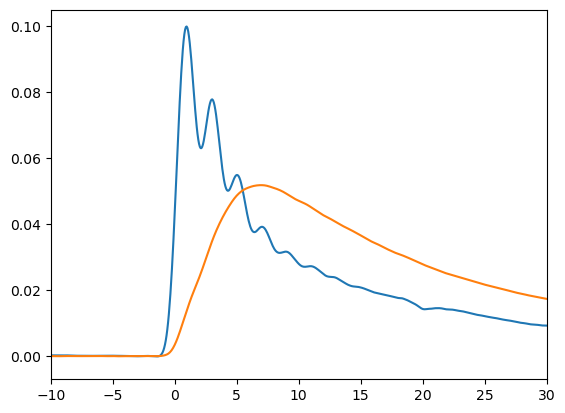

In [146]:
# data=joblib.load("/mnt/sda2//scope_data/pulse_shape/preamp_v5_30pF_a_averaged.joblib",)
data=joblib.load("/mnt/sda2//scope_data/pulse_shape/preamp_v5b_A_sipm_calibration_averaged.joblib",)
template_sipm = data["averaged_pulse_1pe_volt"]
# average_pulse/=max(average_pulse)
plot(data["time_series_ns"], template_sipm*20)
plot(time_series, trace_original_avg)


xlim(-10,30)

In [147]:
time_series_sipm = data["time_series_ns"]
tau_fiber = 1.9
tau_scintillator = 5

def make_scintillator_pulse(time_series, tau_fiber, tau_scintillator, amplitude=1, time_offset=0):
    # Set normed=0 to get a PDF
    time_distribution = hp.Pulse(time_series, 1, 0, tau_fiber, tau_scintillator, normed=0)
    # make this into [density per bin] by multiplying bin size:
    time_distribution = time_distribution * (time_series[1]-time_series[0])
    fake_trace = np.convolve(template_sipm,time_distribution, mode="same")
    fake_trace = fake_trace* amplitude
    fake_trace = scipy.ndimage.shift(fake_trace, -time_offset)
    return fake_trace

def least_square(args):
    tau_fit, amplitude, time_offset = args
    model_y = make_scintillator_pulse(time_series_sipm, tau_fiber, tau_fit, amplitude=amplitude, time_offset=time_offset)
    return np.sum((model_y-trace_original_avg)[1000:-1000]**2)

m = scipy.optimize.minimize(least_square, [3, 0.08, -2], method="Powell")

# tau_scan = np.linspace(2,8,10)
# chi2 = []
# for tau_scintillator in tau_scan:
#     fake_trace = make_scintillator_pulse(time_series_sipm, tau_fiber, tau_scintillator)
#     fake_trace *= max(trace_original_avg)
#     chi2.append(np.linalg.norm(fake_trace[1024:-1024] - trace_original_avg))
    

print(m.x)

/tmp/ipykernel_1027995/371007710.py:18: RuntimeWarning: overflow encountered in square
  return np.sum((model_y-trace_original_avg)[1000:-1000]**2)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[ 5.27200976 24.95942548 18.71850209]


[ 5.27200976 24.95942548 18.71850209]


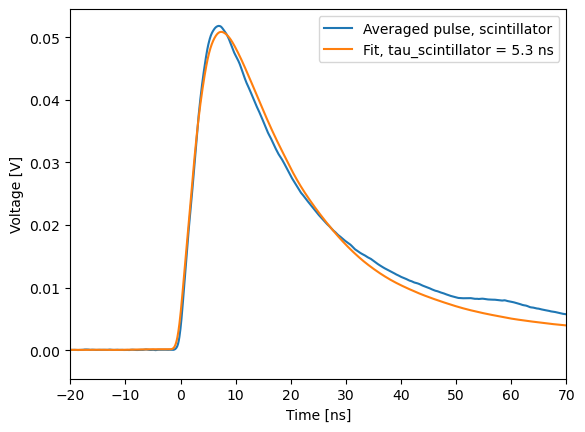

In [148]:
trace_fit = make_scintillator_pulse(time_series, tau_fiber, *m.x)
plot(time_series[60:-60], trace_original_avg[60:-60], label="Averaged pulse, scintillator")
plot(time_series[60:-60], trace_fit[60:-60], label=f"Fit, tau_scintillator = {m.x[0]:.2} ns")
legend()
xlabel("Time [ns]")
ylabel("Voltage [V]")
print(m.x)
tau_scintillator_measured = m.x[2]

xlim(-20,70)
savefig(config.scope+"plots/scintillator_average_pulse_fit.jpg")

In [151]:
calib_coeff = m.x[1]/max(trace_original_avg)
integral_1pe = sum(template_sipm[(data["time_series_ns"]>-10)&(data["time_series_ns"]<100)])
amplitude_1pe = max(template_sipm)
print(calib_coeff, integral_1pe, amplitude_1pe)

481.78535416962814 0.91328233 0.0049922196


(0.0, 50.0)

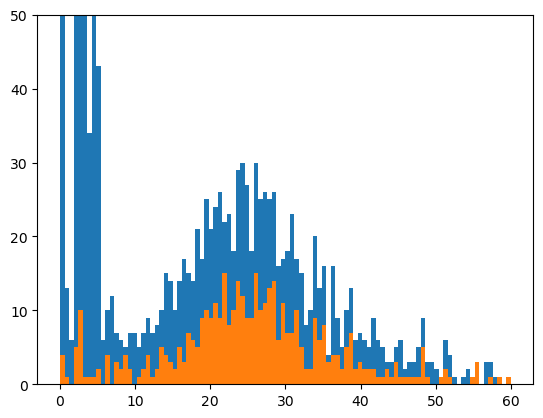

In [150]:
trace_pe = trace_amp*calib_coeff
hist(trace_pe, bins=100,range=(0,60));
hist(trace_pe[mask_dt], bins=100,range=(0,60));
# axvline(np.median(trace_pe),color="r")
# axvline(np.mean(trace_pe),color="r", linestyle=":")
ylim(0,50)